In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

# Define model and create sample trajectory

In [3]:
M  = 2                  # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1./7            # recovery rate of asymptomatic infectives
gE = 0.2
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
E0  = np.array([10, 10])
Ia0 = np.array([10, 10])  # each age group has asymptomatic infectives
Is0 = np.array([10, 10])   # and also symptomatic infectives
R0  = np.array([0, 0])  # there are no recovered individuals initially
S0  = Ni - (E0 + Ia0 + Is0 + R0)

Tf = 100 
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs, 'gE':gE, 'fsa':fsa}

# use pyross stochastic to generate traj and save 

sto_model = pyross.stochastic.SEIR(parameters, M, Ni)
data=sto_model.simulate(S0, E0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('SEIR_latent_traj.npy', data_array)

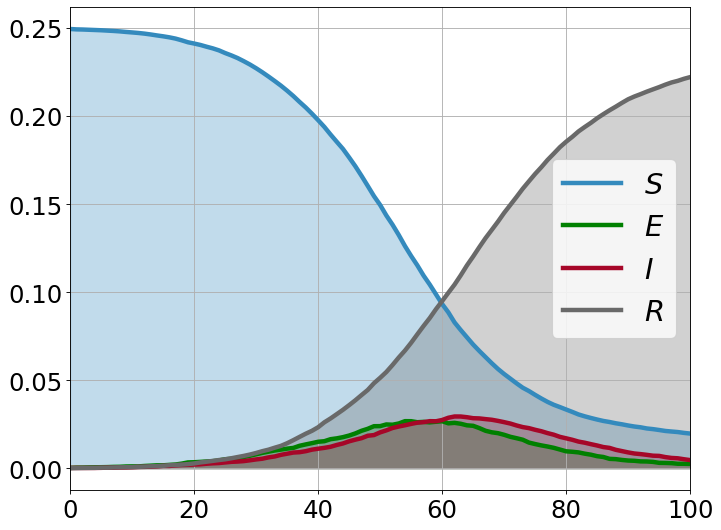

In [4]:
# plot the data and obtain the epidemic curve for one age group 

S  = data['X'][:,0]
E  = data['X'][:,2]
Ia = data['X'][:,4]
Is = data['X'][:,6]
t = data['t']

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})


plt.fill_between(t, 0, S/N, color="#348ABD", alpha=0.3)
plt.plot(t, S/N, '-', color="#348ABD", label='$S$', lw=4)

plt.plot(t, E/N, '-', color="green", label='$E$', lw=4)
plt.fill_between(t, 0, E/N, color='green', alpha=0.3)


plt.fill_between(t, 0, Is/N, color='#A60628', alpha=0.3)
plt.plot(t, Is/N, '-', color='#A60628', label='$I$', lw=4)

R=Ni[0]-S-Ia-Is-E; 
plt.fill_between(t, 0, R/N, color="dimgrey", alpha=0.3)
plt.plot(t, R/N, '-', color="dimgrey", label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)

# Infer parameters based on part of the trajectory

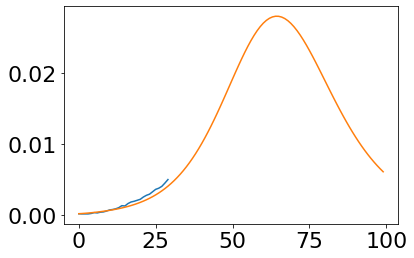

In [5]:
# load the data and rescale to intensive variables 
Tf_inference = 30 # truncate to only getting the first few datapoints 
Nf_inference = Tf_inference+1

x = np.load('SEIR_latent_traj.npy').astype('float')
x = (x/N)[:Nf_inference]
steps = 101


fltr=np.repeat(np.array([False, False, False, True]), M)
obs=x[:, fltr] # need to full obs for inference, don't change here 
x0=x[0]

# estimate mean and cov 
estimator = pyross.inference.SEIR(parameters, M, fi, int(N), steps)
det_model = pyross.deterministic.SEIR(parameters, int(M), fi)
xm,full_cov = estimator.obtain_full_mean_cov(x[0,:], Tf, Nf, det_model, contactMatrix)
plt.plot(x[1:,3*M])
plt.plot(xm[:,3*M])
plt.show()

In [6]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 
logp = estimator.minus_logp_red(parameters, x0, obs[1:], fltr, Tf_inference, Nf_inference, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-471.2979483296961
0.2659339904785156


In [8]:
# make parameter guesses and set up bounds for each parameter 
eps = 1e-4 # step used to calculate hessian in the optimisation algorithm 
alpha_g = 0.2
alpha_std = 0.1 
alpha_bounds = (eps, 1-2*eps)
# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 

beta_g = 0.04
beta_std = 0.05 
beta_bounds = (eps, 1)

gIa_g = 0.145
gIa_std = 0.1
gIa_bounds = (eps, 1)

gIs_g = 0.145
gIs_std = 0.2 
gIs_bounds = (eps, 1) 

gE_g = gE 
gE_std = 0.05
gE_bounds = (eps, 1)

fsa_g = 0.8

E0_g = E0/N 
E_std = E0_g*0.4 
bounds_for_E = np.tile([0.1/N, 100/N], M).reshape(M, 2)

Ia0_g = Ia0/N
Ia_std = Ia0_g*0.4 
bounds_for_Ia = np.tile([0.1/N, 100/N], M).reshape(M, 2)

Is0_g = Is0/N 
Is_std = Is0_g*0.2 
bounds_for_Is = np.tile([0.1/N, 100/N], M).reshape(M, 2)

S0_g = S0/N
S_std = Ia_std*np.sqrt(4)
bounds_for_S = np.tile([0.1/N, 1], M).reshape(M, 2)

# optimisation parameters 
ftol = 1e-5 # the relative tol in (-logp)  

# # set up bounds for the rest of the params 
# # the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 
bounds = np.array([alpha_bounds, beta_bounds, gIa_bounds, gIs_bounds, gE_bounds,
                   *bounds_for_S, *bounds_for_E, *bounds_for_Ia, *bounds_for_Is])
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, gE_g, *S0_g, *E0_g, *Ia0_g, *Is0_g])
stds = np.array([alpha_std, beta_std, gIa_std, gIs_std, gE_std, *S_std, *E_std, *Ia_std, *Is_std])
start_time = time.time()
params = estimator.latent_inference(guess, stds, obs, fltr, Tf_inference, Nf_inference, contactMatrix, bounds, 
                                    global_max_iter=15, global_ftol_factor=1e3, 
                                    verbose=True, ftol=ftol, eps=eps) 
end_time = time.time()
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 13 (seed=445718, Thu Apr 30 21:16:41 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -5.454843771968320e+02 1.0e+00 9.63e-01  1e-05  6e-02 0:02.8
    2     32 -5.356123447232317e+02 1.2e+00 9.81e-01  1e-05  6e-02 0:05.2
    3     48 -5.455205123432946e+02 1.3e+00 9.67e-01  1e-05  6e-02 0:07.5
    5     80 -5.450726706543010e+02 1.5e+00 8.75e-01  1e-05  6e-02 0:11.9
    7    112 -5.429785155609538e+02 1.5e+00 8.31e-01  1e-05  6e-02 0:16.1
   10    160 -5.449942664733564e+02 1.8e+00 8.04e-01  1e-05  5e-02 0:23.7
   14    224 -5.453036880564114e+02 2.2e+00 7.41e-01  1e-05  5e-02 0:31.5
Optimal value (global minimisation):  -546.2529083936405
Starting local minimisation...
Optimal value (local minimisation):  -546.7456106887596
55.24198126792908


In [9]:
np.save('latent_SEIR_params.npy', params)

best estimates for params:  [0.21863006 0.02153419 0.16223562 0.15658177 0.21400052]
best estimates for initial conditions:  [2.49399917e-01 7.49399260e-01 2.00704826e-04 2.01294379e-04
 2.00118322e-04 2.01674105e-04 1.99686318e-04 2.00609076e-04]


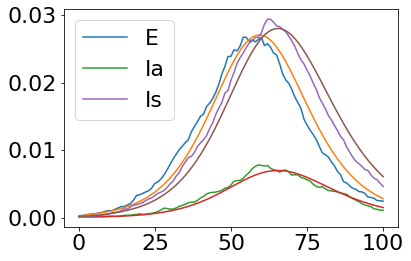

In [10]:
params = np.load('latent_SEIR_params.npy')
print('best estimates for params: ', params[:5])
print('best estimates for initial conditions: ', params[5:])

parameters = {'alpha':params[0], 'beta':params[1], 'gIa':params[2], 'gIs':params[3], 'gE':params[4], 'fsa':0.8}
estimator.set_params(parameters)
x0 = params[5:]
x_det = estimator.integrate(x0, 0, Tf, Nf, det_model, contactMatrix)
x_full = np.load('SEIR_latent_traj.npy')/N
plt.plot(x_full[:,1*M], label='E')
plt.plot(x_det[:, 1*M])
plt.plot(x_full[:,2*M], label='Ia')
plt.plot(x_det[:, 2*M])
plt.plot(x_full[:,3*M], label='Is')
plt.plot(x_det[:, 3*M])
plt.legend()
plt.show()

In [12]:
hess_params, hess_init = estimator.hessian_latent(params, guess, stds, obs[1:], fltr, 
                                                    Tf_inference, Nf_inference, contactMatrix, 
                                                        beta_rescale=2, eps=1e-4)

In [15]:
cov_params = np.linalg.inv(hess_params)
cov_init = np.linalg.inv(hess_init)
print(cov_params)

[[ 2.36213699e-02 -4.22815179e-05  1.37033104e-02 -1.03348493e-03
   7.95841198e-03]
 [-4.22815179e-05  1.28266960e-05  1.28418362e-04  1.04062854e-04
  -7.71517595e-05]
 [ 1.37033104e-02  1.28418362e-04  1.33224932e-02  1.35765968e-04
   4.94570177e-03]
 [-1.03348493e-03  1.04062854e-04  1.35765968e-04  1.53803691e-03
  -1.52618491e-04]
 [ 7.95841198e-03 -7.71517595e-05  4.94570177e-03 -1.52618491e-04
   4.86516775e-03]]


# Compare forecast based on inferred parameters to full trajectory

In [16]:
parameters = {'alpha': params[0], 'beta': params[1], 'gIa': params[2], 'gIs': params[3],
              'gE':params[4],
            'S0':params[5: 5+M],
            'E0':params[5+M:5+2*M],
            'Ia0':params[5+2*M:5+3*M],
              'Is0':params[5+3*M:],
              'fsa':fsa,
             'cov_init':cov_init, 'cov_params':cov_params}

# Initialise pyross forecast module
model_forecast = pyross.forecast.SEIR_latent(parameters, M, Ni)

In [17]:
# Number of simulations over which we average
Ns = 500 

Tf_forecast = Tf
Nf_forecast = Tf_forecast+1


result_forecast = model_forecast.simulate(contactMatrix, Tf_forecast, Nf_forecast,
                                      verbose=True,
                                     Ns=Ns) 

trajectories_forecast = result_forecast['X']
t_forecast = result_forecast['t']

Finished. Time needed for evaluation: 00:00:01


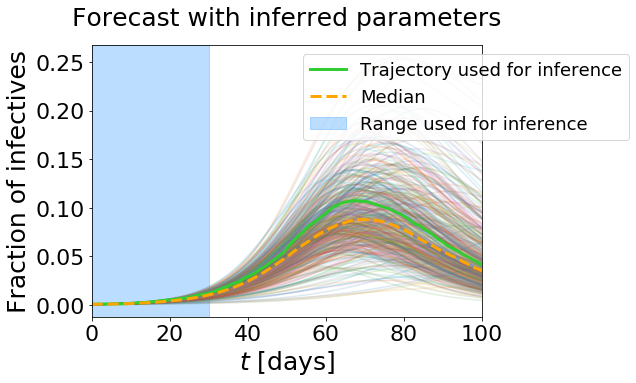

In [19]:
fontsize=25
#

ylabel=r'Fraction of infectives'
#

# Plot total number of symptomatic infectives
cur_trajectories_forecast = np.sum( trajectories_forecast[:,2*M:,:] , axis = 1)
cur_mean_forecast = np.mean( cur_trajectories_forecast, axis=0)
percentile = 10
percentiles_lower = np.percentile(cur_trajectories_forecast,percentile,axis=0)
percentiles_upper = np.percentile(cur_trajectories_forecast,100-percentile,axis=0)
percentiles_median = np.percentile(cur_trajectories_forecast,50,axis=0)

data_array = np.load('SEIR_latent_traj.npy')
cur_trajectory_underlying = np.sum( data_array[:,2*M:] ,axis=1 )

#
# Plot trajectories
#
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.axvspan(0, Tf_inference, 
           label='Range used for inference',
           alpha=0.3, color='dodgerblue')
ax.set_title(r'Forecast with inferred parameters',
             y=1.05,
            fontsize=fontsize)
for i,e in enumerate(cur_trajectories_forecast):
    ax.plot(t_forecast,e/N,
            alpha=0.15,
           )
ax.plot(cur_trajectory_underlying/N,
        lw=3,
        color='limegreen',
       label='Trajectory used for inference')

ax.plot(t_forecast,percentiles_median/N,
                alpha=1,ls='--',
        color='orange',label='Median',
       lw=3)
''' # remove comments to plot percentiles
ax.plot(t_forecast,percentiles_lower/N,
                alpha=1,
        lw=2,
        label='Percentiles',
        ls='dotted',
        color='red',
       )
ax.plot(t_forecast,percentiles_upper/N,
                alpha=1,
        lw=2,
        color='red',
        ls='dotted',
       )
''';

ax.set_xlim(0,np.max(t_forecast))
ax.set_ylabel(ylabel,fontsize=fontsize)
ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
ax.legend(loc='upper right',bbox_to_anchor=(1.4,1),
          fontsize=18)
plt.show(fig)
plt.close(fig)